# 🎓 Projeto de Mineração de Dados: Infraestrutura Escolar e Desempenho no ENEM

## 🎯 Objetivo do Trabalho
Este projeto aplica a metodologia **KDD (Knowledge Discovery in Databases)** para investigar a correlação entre a qualidade da **infraestrutura física** das escolas brasileiras e o **desempenho acadêmico** médio de seus alunos no Exame Nacional do Ensino Médio (ENEM).

O objetivo central é segmentar as escolas em grupos (clusters) com características semelhantes e identificar se instalações como laboratórios, bibliotecas e saneamento são fatores determinantes para notas mais altas.

## 🛠️ Metodologia Aplicada
Para garantir rigor científico e robustez na análise, o projeto segue as seguintes etapas técnicas:

1.  **Leitura e Cruzamento de Dados:** Integração das bases do Censo Escolar e do ENEM utilizando chaves primárias (`CO_ENTIDADE` e `CO_ESCOLA`), com seleção segura de atributos por nome.
2.  **Pré-processamento Robusto:**
    * **Engenharia de Atributos:** Criação de indicadores sintéticos (`SCORE_INFRA` e `NOTA_GERAL`).
    * **Tratamento de Outliers:** Utilização do **RobustScaler** para normalização dos dados. Esta técnica utiliza a mediana e o intervalo interquartil (IQR), garantindo que escolas com notas extremas ou erros de cadastro não distorçam a formação dos grupos.
3.  **Definição de Clusters (K-Means):** Aplicação do algoritmo K-Means para agrupar as escolas.
    * *Validação:* Uso do **Método do Cotovelo (Elbow Method)** para determinar matematicamente o número ideal de grupos ($K$), evitando definições arbitrárias.
4.  **Explicabilidade (XAI):** Implementação de uma **Árvore de Decisão** sobre os clusters gerados para extrair regras de negócio legíveis (ex: "Escolas com Infraestrutura > X tendem a pertencer ao Grupo Y").

## 📂 Fontes de Dados (INEP 2024)
* **Censo Escolar:** Dados detalhados sobre a estrutura física das escolas (abastecimento de água, energia, laboratórios, internet, etc.).
* **Microdados do ENEM:** Notas finais dos alunos agregadas por área do conhecimento.
* Link onde as bases de dados podem ser baixadas:
https://download.inep.gov.br/dados_abertos/microdados_censo_escolar_2024.zip
https://download.inep.gov.br/microdados/microdados_enem_2024.zip

### 1. Coleta e Integração dos Dados

Nesta etapa, realizamos a leitura dos arquivos brutos (Raw Data). Para otimizar o uso de memória e processamento, aplicamos técnicas de **Seleção de Atributos** (Feature Selection) diretamente na leitura:

1.  **Censo Escolar:** Selecionamos apenas as colunas de identificação (ID, Estado, Dependência) e os indicadores de infraestrutura (Água, Energia, Laboratórios, Internet).
2.  **ENEM:** Carregamos apenas as colunas de notas e o ID da escola. Como o objetivo é avaliar a escola, realizamos imediatamente uma **agregação (groupby)** para calcular a média das notas de todos os alunos daquela instituição.
3.  **Fusão (Merge):** Unificamos as duas tabelas usando o código da escola como chave. Utilizamos um `inner join` para garantir que analisaremos apenas escolas que possuem dados em **ambas** as bases.

In [ ]:
import pandas as pd
import numpy as np

# --- CONFIGURAÇÃO DOS ARQUIVOS ---
caminho_censo = '/content/microdados_ed_basica_2024.csv'
caminho_enem  = '/content/RESULTADOS_2024.csv'

# 1. Definição das Colunas de Interesse (Censo)
cols_censo = [
    'CO_ENTIDADE', 'NO_ENTIDADE', 'SG_UF', 'TP_DEPENDENCIA', 'TP_LOCALIZACAO',
    'IN_AGUA_POTAVEL', 'IN_ENERGIA_REDE_PUBLICA', 'IN_ESGOTO_REDE_PUBLICA',
    'IN_BIBLIOTECA', 'IN_LABORATORIO_CIENCIAS', 'IN_LABORATORIO_INFORMATICA',
    'IN_INTERNET', 'IN_QUADRA_ESPORTES'
]

print("--- INICIANDO PROCESSO DE ETL (EXTRAÇÃO, TRANSFORMAÇÃO E CARGA) ---")

try:
    # --- LEITURA DO CENSO ---
    print("1. Carregando Censo Escolar...")
    df_censo = pd.read_csv(caminho_censo, sep=';', encoding='latin1', usecols=cols_censo)
    print(f"   -> Censo carregado: {len(df_censo)} escolas encontradas.")

    # --- LEITURA DO ENEM (Otimizada) ---
    print("2. Carregando e Agrupando dados do ENEM...")

    # Mapeamento de colunas por índice (para arquivos sem cabeçalho ou layout fixo)
    # 2: Escola, 22-25: Notas Objetivas, 41: Redação
    indices_enem = [2, 22, 23, 24, 25, 41]

    df_enem = pd.read_csv(
        caminho_enem,
        sep=';',
        encoding='latin1',
        header=None,            # Indica que não há cabeçalho
        usecols=indices_enem    # Carrega apenas o necessário para economizar RAM
    )

    # Renomear colunas para facilitar manipulação
    df_enem.columns = ['CO_ESCOLA', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']

    # Tratamento inicial: Converter ID para numérico e remover nulos
    df_enem['CO_ESCOLA'] = pd.to_numeric(df_enem['CO_ESCOLA'], errors='coerce')
    df_enem.dropna(subset=['CO_ESCOLA'], inplace=True)
    df_enem['CO_ESCOLA'] = df_enem['CO_ESCOLA'].astype(int)

    # Agregação: Calcular a média das notas por escola
    df_enem_agrupado = df_enem.groupby('CO_ESCOLA').agg({
        'NU_NOTA_CN': 'mean',
        'NU_NOTA_CH': 'mean',
        'NU_NOTA_LC': 'mean',
        'NU_NOTA_MT': 'mean',
        'NU_NOTA_REDACAO': 'mean',
        'CO_ESCOLA': 'count' # Conta quantos alunos fizeram a prova
    }).rename(columns={'CO_ESCOLA': 'QTD_ALUNOS'}).reset_index()

    print(f"   -> ENEM processado: {len(df_enem_agrupado)} escolas com notas calculadas.")

    # --- CRUZAMENTO DAS BASES (MERGE) ---
    print("3. Cruzando as bases de dados...")
    df_final = pd.merge(df_censo, df_enem_agrupado, left_on='CO_ENTIDADE', right_on='CO_ESCOLA', how='inner')

    print("\n" + "="*50)
    print(f"✅ BASE DE DADOS PRONTA!")
    print(f"Total de Escolas para Análise: {len(df_final)}")
    print("="*50)

    # Exibir amostra dos dados
    display(df_final.head())

except Exception as e:
    print(f"❌ Erro no processamento: {e}")

--- INICIANDO PROCESSO DE ETL (EXTRAÇÃO, TRANSFORMAÇÃO E CARGA) ---
1. Carregando Censo Escolar...
   -> Censo carregado: 216571 escolas encontradas.
2. Carregando e Agrupando dados do ENEM...
   -> ENEM processado: 29146 escolas com notas calculadas.
3. Cruzando as bases de dados...

✅ BASE DE DADOS PRONTA!
Total de Escolas para Análise: 25338


,SG_UF,NO_ENTIDADE,CO_ENTIDADE,TP_DEPENDENCIA,TP_LOCALIZACAO,IN_AGUA_POTAVEL,IN_ENERGIA_REDE_PUBLICA,IN_ESGOTO_REDE_PUBLICA,IN_BIBLIOTECA,IN_LABORATORIO_CIENCIAS,IN_LABORATORIO_INFORMATICA,IN_QUADRA_ESPORTES,IN_INTERNET,CO_ESCOLA,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,QTD_ALUNOS
0,RO,EEEFM EURIDICE LOPES PEDROSO,11024682,2,1,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,11024682,443.447059,461.594444,481.494444,469.814706,552.777778,62
1,RO,EEEMTI JUSCELINO KUBITSCHEK DE OLIVEIRA,11024968,2,1,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,11024968,494.488889,512.278571,523.017857,528.459259,686.428571,32
2,RO,COLEGIO TIRADENTES DA POLICIA MILITAR - CTPM XI,11025638,2,1,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,11025638,461.037838,458.411111,490.994444,469.021622,632.777778,46
3,RO,CENTRO ESTADUAL DE EDUCACAO DE JOVENS E ADULTO...,11006757,2,1,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,11006757,464.340000,426.800000,503.120000,459.200000,428.000000,25
4,RO,EEEFM CORA CORALINA,11006773,2,1,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,11006773,452.595833,456.364286,485.832143,459.895833,557.857143,59


### 2. Engenharia de Atributos e Pré-processamento

Nesta etapa, transformamos as colunas originais em indicadores que representam melhor o objeto de estudo (a escola).

1.  **Criação do SCORE_INFRA:** Somamos os itens de infraestrutura (Laboratórios, Biblioteca, Internet, etc.) para criar uma pontuação única de 0 a N que representa a "Qualidade da Estrutura".
2.  **Criação da NOTA_GERAL:** Calculamos a média aritmética das 5 notas do ENEM (Linguagens, Humanas, Natureza, Matemática e Redação) para ter um único indicador de "Desempenho Acadêmico".
3.  **Filtro de Relevância:** Removemos escolas com menos de 10 alunos participantes no ENEM para evitar distorções estatísticas (outliers gerados por amostras muito pequenas).
4.  **Normalização (RobustScaler):** Aplicamos o RobustScaler nas variáveis de interesse. Diferente de métodos comuns (como MinMax ou Standard), o RobustScaler usa a mediana e quartis, tornando o modelo imune a outliers extremos que poderiam distorcer os grupos.

In [ ]:
from sklearn.preprocessing import RobustScaler

print("--- INICIANDO ENGENHARIA DE ATRIBUTOS E PRÉ-PROCESSAMENTO ---")

# 1. Engenharia de Atributos (Criação de Variáveis)
# Selecionar colunas de infraestrutura (começam com 'IN_')
cols_infra = [col for col in df_final.columns if col.startswith('IN_')]
df_final['SCORE_INFRA'] = df_final[cols_infra].sum(axis=1)

# Selecionar colunas de notas (começam com 'NU_NOTA_')
cols_notas = [col for col in df_final.columns if col.startswith('NU_NOTA_')]
df_final['NOTA_GERAL'] = df_final[cols_notas].mean(axis=1)

print(f"   -> Variáveis criadas: SCORE_INFRA (0 a {len(cols_infra)}) e NOTA_GERAL.")

# 2. Filtro de Ruído (Remover escolas com poucos alunos)
qtd_antes = len(df_final)
df_final = df_final[df_final['QTD_ALUNOS'] >= 10]
print(f"   -> Filtro aplicado: {qtd_antes - len(df_final)} escolas pequenas removidas.")

# 3. Seleção e Normalização para o Modelo
# Vamos usar apenas as duas variáveis principais para o agrupamento
X = df_final[['SCORE_INFRA', 'NOTA_GERAL']]

# Aplicando RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Criando um DataFrame com os dados normalizados (para visualização e uso no modelo)
df_scaled = pd.DataFrame(X_scaled, columns=['SCORE_INFRA', 'NOTA_GERAL'], index=df_final.index)

print("\n" + "="*50)
print("✅ DADOS PRONTOS PARA O MODELO!")
print("="*50)

# Visualizar estatísticas antes e depois da escala
print("\n--- Estatísticas Originais ---")
display(df_final[['SCORE_INFRA', 'NOTA_GERAL']].describe().round(2))

print("\n--- Dados Normalizados (RobustScaler) ---")
display(df_scaled.head())

--- INICIANDO ENGENHARIA DE ATRIBUTOS E PRÉ-PROCESSAMENTO ---
   -> Variáveis criadas: SCORE_INFRA (0 a 8) e NOTA_GERAL.
   -> Filtro aplicado: 3128 escolas pequenas removidas.

✅ DADOS PRONTOS PARA O MODELO!

--- Estatísticas Originais ---


,SCORE_INFRA,NOTA_GERAL
count,22210.00,22195.00
mean,6.54,525.85
std,1.29,61.56
min,0.00,301.09
25%,6.00,482.53
50%,7.00,513.29
75%,8.00,562.23
max,8.00,787.12



--- Dados Normalizados (RobustScaler) ---


,SCORE_INFRA,NOTA_GERAL
0,-0.5,-0.394748
1,0.0,0.447264
2,0.0,-0.135994
3,-0.5,-0.715118
4,0.0,-0.386174


### 3. Modelagem: Agrupamento (Clustering)

Nesta etapa, aplicamos algoritmos de aprendizado de máquina não supervisionado para encontrar padrões nos dados.

1.  **Método do Cotovelo (Elbow Method):** Rodamos o K-Means várias vezes (de 1 a 10 grupos) e calculamos a "Inércia" (soma dos erros quadrados). O objetivo é encontrar o ponto onde adicionar mais grupos não reduz significativamente o erro (o "cotovelo" do gráfico).
2.  **Aplicação do K-Means:** Com base no método do cotovelo e no conhecimento do negócio, definimos o número ideal de clusters ($K=4$) e segmentamos as escolas.
3.  **Visualização:** Plotamos um gráfico de dispersão para visualizar como os grupos se separam com base na Infraestrutura e na Nota.

--- INICIANDO MODELAGEM E CLUSTERIZAÇÃO ---
1. Dados preparados: 22195 escolas válidas para análise.
2. Calculando inércia para K=1 a 10...


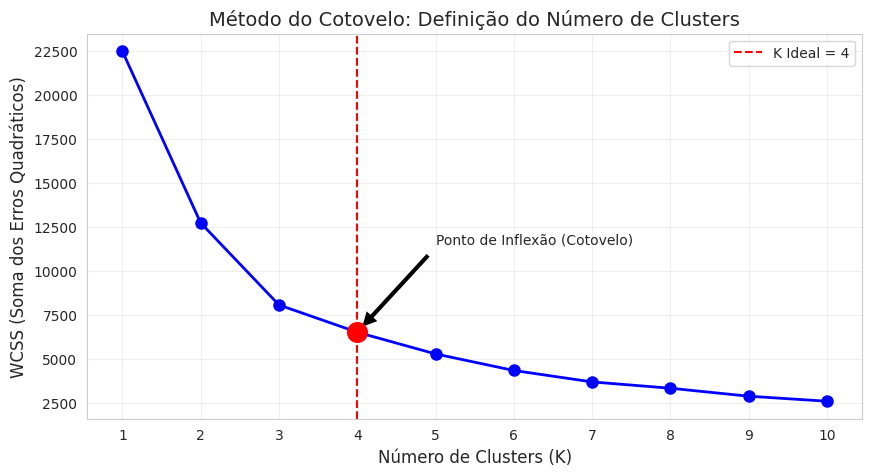


3. Aplicando K-Means com 4 grupos...


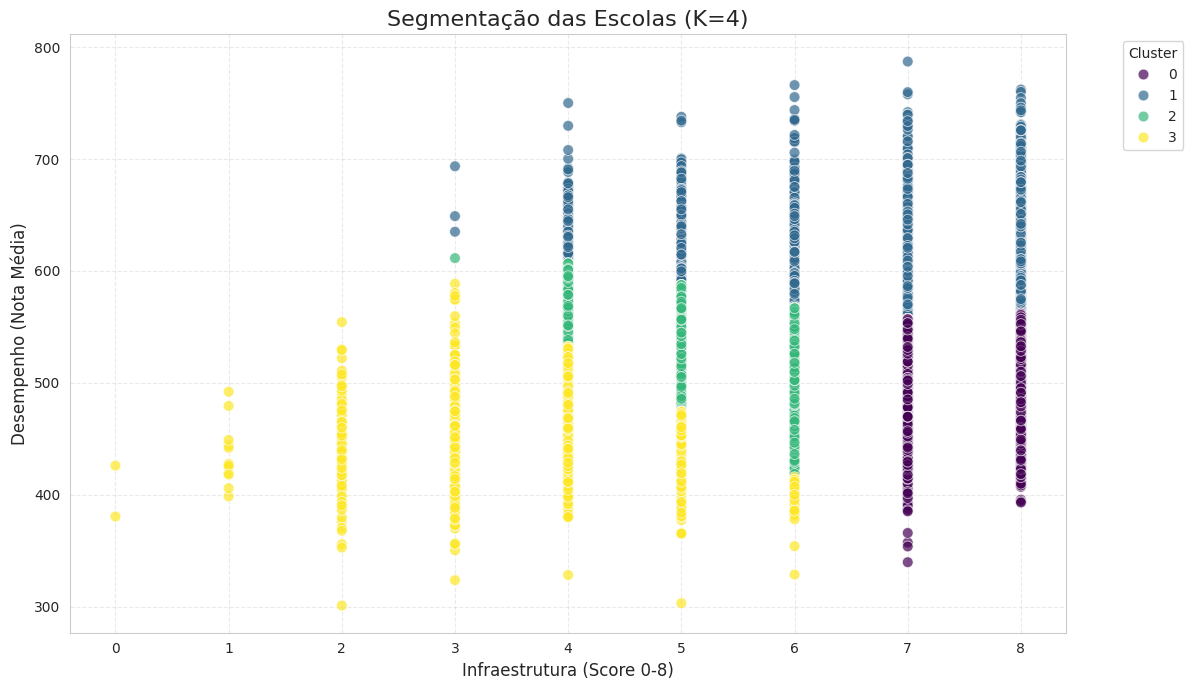


✅ Processo de modelagem concluído com sucesso.


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

print("--- INICIANDO MODELAGEM E CLUSTERIZAÇÃO ---")

# 1. LIMPEZA E PREPARAÇÃO
# Removemos linhas com valores nulos para evitar erros no K-Means
df_final = df_final.dropna(subset=['SCORE_INFRA', 'NOTA_GERAL']).copy()

# Selecionamos as features e normalizamos com RobustScaler (resistente a outliers)
X = df_final[['SCORE_INFRA', 'NOTA_GERAL']]
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

print(f"1. Dados preparados: {len(df_final)} escolas válidas para análise.")

# 2. MÉTODO DO COTOVELO (ELBOW METHOD)
print("2. Calculando inércia para K=1 a 10...")
wcss = []
intervalo_k = range(1, 11)

for k in intervalo_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plotagem do Gráfico do Cotovelo com destaque para K=4
plt.figure(figsize=(10, 5))
plt.plot(intervalo_k, wcss, marker='o', linestyle='-', color='b', linewidth=2, markersize=8)

# Adicionando destaque visual para K=4
k_destaque = 4
plt.axvline(x=k_destaque, color='r', linestyle='--', label=f'K Ideal = {k_destaque}')
plt.scatter(k_destaque, wcss[k_destaque-1], s=200, c='red', zorder=5)
plt.annotate('Ponto de Inflexão (Cotovelo)',
             xy=(k_destaque, wcss[k_destaque-1]),
             xytext=(k_destaque+1, wcss[k_destaque-1]+5000),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('Método do Cotovelo: Definição do Número de Clusters', fontsize=14)
plt.xlabel('Número de Clusters (K)', fontsize=12)
plt.ylabel('WCSS (Soma dos Erros Quadráticos)', fontsize=12)
plt.xticks(intervalo_k)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3. APLICAÇÃO DO K-MEANS (K=4)
print(f"\n3. Aplicando K-Means com {k_destaque} grupos...")
kmeans_final = KMeans(n_clusters=k_destaque, random_state=42, n_init=10)
df_final['CLUSTER'] = kmeans_final.fit_predict(X_scaled)

# 4. VISUALIZAÇÃO DOS CLUSTERS
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df_final,
    x='SCORE_INFRA',
    y='NOTA_GERAL',
    hue='CLUSTER',
    palette='viridis',
    s=60,
    alpha=0.7,
    edgecolor='w'
)
plt.title(f'Segmentação das Escolas (K={k_destaque})', fontsize=16)
plt.xlabel('Infraestrutura (Score 0-8)', fontsize=12)
plt.ylabel('Desempenho (Nota Média)', fontsize=12)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

print("\n✅ Processo de modelagem concluído com sucesso.")

### 4. Interpretação e Perfilamento dos Clusters

Nesta etapa, transformamos os números dos clusters em **conhecimento de negócio**. Agrupamos os dados pelo `CLUSTER` definido e calculamos as médias das variáveis originais para traçar o perfil de cada grupo.

**Objetivo:** Responder a perguntas como:
* Qual grupo tem o melhor desempenho no ENEM?
* Esse grupo de alto desempenho também possui a melhor infraestrutura?
* Existe algum grupo com infraestrutura boa, mas notas baixas (ou vice-versa)?

Além das médias, contaremos quantas escolas existem em cada grupo para entender a representatividade de cada segmento.

--- INICIANDO PERFILAMENTO E VISUALIZAÇÃO ---
Tabela de Perfil dos Clusters:


,SCORE_INFRA,NOTA_GERAL,QTD_ALUNOS,QTD_ESCOLAS,%_TOTAL
CLUSTER,,,,,
1,7.11,614.61,37.86,5379,24.24
2,5.70,503.85,39.05,6187,27.88
0,7.44,502.71,51.41,8441,38.03
3,4.06,459.15,40.41,2188,9.86


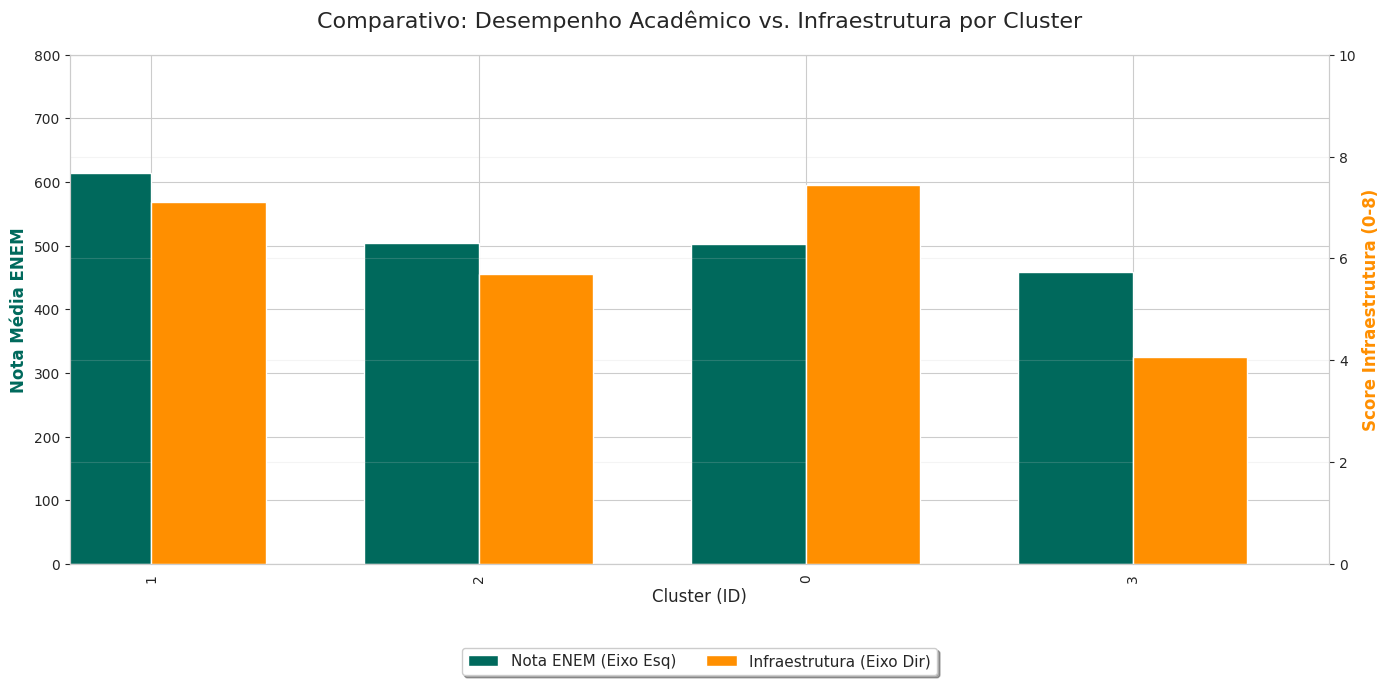

In [ ]:
import matplotlib.pyplot as plt

print("--- INICIANDO PERFILAMENTO E VISUALIZAÇÃO ---")

# 1. Agrupamento e Cálculo de Médias
perfil_clusters = df_final.groupby('CLUSTER').agg({
    'SCORE_INFRA': 'mean',
    'NOTA_GERAL': 'mean',
    'QTD_ALUNOS': 'mean',
    'CO_ESCOLA': 'count'
}).rename(columns={'CO_ESCOLA': 'QTD_ESCOLAS'})

# Ordenar por Nota Geral
perfil_clusters = perfil_clusters.sort_values('NOTA_GERAL', ascending=False)

# Cálculo de %
perfil_clusters['%_TOTAL'] = (perfil_clusters['QTD_ESCOLAS'] / perfil_clusters['QTD_ESCOLAS'].sum()) * 100

print("Tabela de Perfil dos Clusters:")
display(perfil_clusters.round(2))

# --- GRÁFICO AJUSTADO ---
fig, ax1 = plt.figure(figsize=(14, 7)), plt.gca() # Aumentei um pouco a largura
ax2 = ax1.twinx() # Eixo secundário

# Plotagem das Barras (com larguras e posições ajustadas para não sobrepor)
width = 0.35 # Largura das barras

perfil_clusters['NOTA_GERAL'].plot(kind='bar', color='#00695C', ax=ax1, width=width, position=1, label='Nota ENEM (Eixo Esq)')
perfil_clusters['SCORE_INFRA'].plot(kind='bar', color='#FF8F00', ax=ax2, width=width, position=0, label='Infraestrutura (Eixo Dir)')

# Configurações dos Eixos
ax1.set_ylabel('Nota Média ENEM', color='#00695C', fontsize=12, fontweight='bold')
ax2.set_ylabel('Score Infraestrutura (0-8)', color='#FF8F00', fontsize=12, fontweight='bold')
ax1.set_xlabel('Cluster (ID)', fontsize=12)
ax1.set_title('Comparativo: Desempenho Acadêmico vs. Infraestrutura por Cluster', fontsize=16, pad=20)

# Ajuste da Legenda (Para ficar FORA do gráfico e centralizada)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=11, frameon=True, shadow=True)

# Ajuste de limites para dar um "respiro" visual no topo
ax1.set_ylim(0, 800) # Nota máxima do ENEM aprox
ax2.set_ylim(0, 10)  # Infraestrutura vai até 8

plt.grid(True, alpha=0.2)
plt.tight_layout() # Garante que nada seja cortado na imagem final
plt.show()

### 5. Explicabilidade do Modelo (XAI - Explainable AI)

O algoritmo K-Means agrupa os dados por distância matemática, mas não nos diz *quais* regras ele usou. Para traduzir essa matemática em regras de negócio compreensíveis, treinamos uma **Árvore de Decisão** (Supervisionada) para prever os clusters que acabamos de criar.

Isso nos permite extrair regras lógicas (Se... Então...) baseadas nos dados originais (não normalizados), facilitando a leitura dos resultados para gestores ou educadores.

**Objetivo:** Gerar um diagrama de decisão que mostre os limites exatos de *Nota* e *Infraestrutura* que definem cada perfil.

--- INICIANDO EXPLICABILIDADE LIMPA (ÁRVORE DE DECISÃO) ---


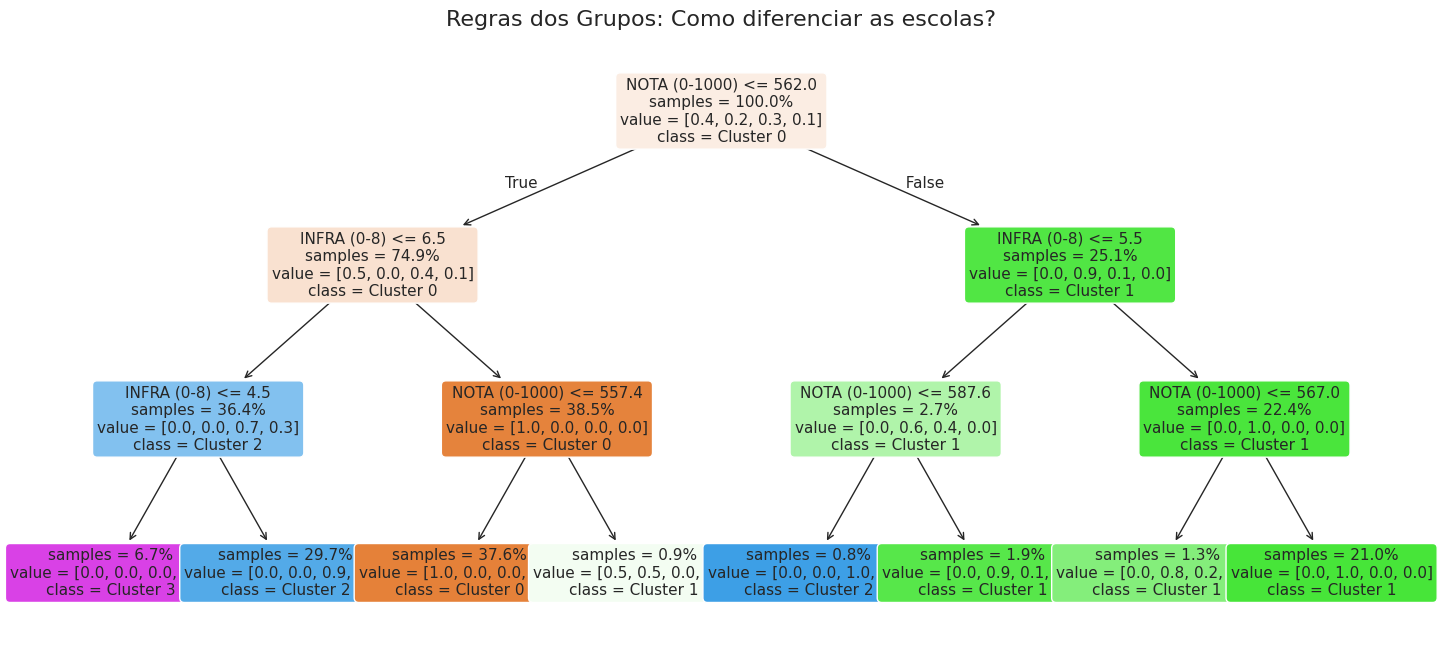


--- RESUMO DAS REGRAS ---
|--- NOTA <= 561.99
|   |--- INFRA <= 6.50
|   |   |--- INFRA <= 4.50
|   |   |   |--- class: 3
|   |   |--- INFRA >  4.50
|   |   |   |--- class: 2
|   |--- INFRA >  6.50
|   |   |--- NOTA <= 557.39
|   |   |   |--- class: 0
|   |   |--- NOTA >  557.39
|   |   |   |--- class: 1
|--- NOTA >  561.99
|   |--- INFRA <= 5.50
|   |   |--- NOTA <= 587.64
|   |   |   |--- class: 2
|   |   |--- NOTA >  587.64
|   |   |   |--- class: 1
|   |--- INFRA >  5.50
|   |   |--- NOTA <= 566.96
|   |   |   |--- class: 1
|   |   |--- NOTA >  566.96
|   |   |   |--- class: 1



In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
import matplotlib.pyplot as plt

print("--- INICIANDO EXPLICABILIDADE LIMPA (ÁRVORE DE DECISÃO) ---")

# 1. Preparação dos Dados
X_tree = df_final[['SCORE_INFRA', 'NOTA_GERAL']]
y_tree = df_final['CLUSTER']

# 2. Treinamento
# max_depth=3 é ideal para slides. Se quiser ainda mais simples, mude para 2.
clf_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
clf_tree.fit(X_tree, y_tree)

# 3. Visualização "Limpa"
plt.figure(figsize=(18, 8)) # Tamanho ajustado

plot_tree(
    clf_tree,
    feature_names=['INFRA (0-8)', 'NOTA (0-1000)'], # Nomes mais curtos e claros
    class_names=[f'Cluster {i}' for i in sorted(y_tree.unique())],
    filled=True,       # Cores para identificar os grupos
    rounded=True,      # Caixas arredondadas (estética)
    fontsize=11,       # Tamanho da fonte
    impurity=False,    # REMOVE O "GINI" (Limpeza)
    precision=1,       # REMOVE DÍGITOS EXTRAS (Limpeza)
    proportion=True    # Mostra % em vez de número absoluto (Opcional, mas ajuda)
)

plt.title("Regras dos Grupos: Como diferenciar as escolas?", fontsize=16)
plt.show()

# 4. Regras em Texto (Resumidas)
print("\n--- RESUMO DAS REGRAS ---")
# Esse comando gera o texto simples se você preferir ler a não ver o gráfico
print(export_text(clf_tree, feature_names=['INFRA', 'NOTA']))

### 6. Investigação Social e Conclusão

Nesta etapa final, cruzamos os clusters matemáticos com uma variável categórica chave: o **Tipo de Dependência Administrativa** (Federal, Estadual, Municipal ou Privada).

Isso nos permite responder à pergunta social mais importante do trabalho:
> *"Os grupos de alta performance e infraestrutura são dominados pelo ensino privado? E onde estão as escolas públicas neste cenário?"*

Para isso, criamos uma **Tabela de Contingência** e um gráfico de barras empilhadas que revela a composição de cada perfil.

--- INICIANDO INVESTIGAÇÃO SOCIAL ---
Composição de cada Cluster por Tipo de Escola (%):


TIPO_ESCOLA,Estadual,Federal,Municipal,Privada
CLUSTER,,,,
0,92.8,1.8,0.4,4.9
1,11.2,7.8,0.3,80.7
2,89.8,0.4,0.5,9.4
3,98.2,0.0,0.3,1.5


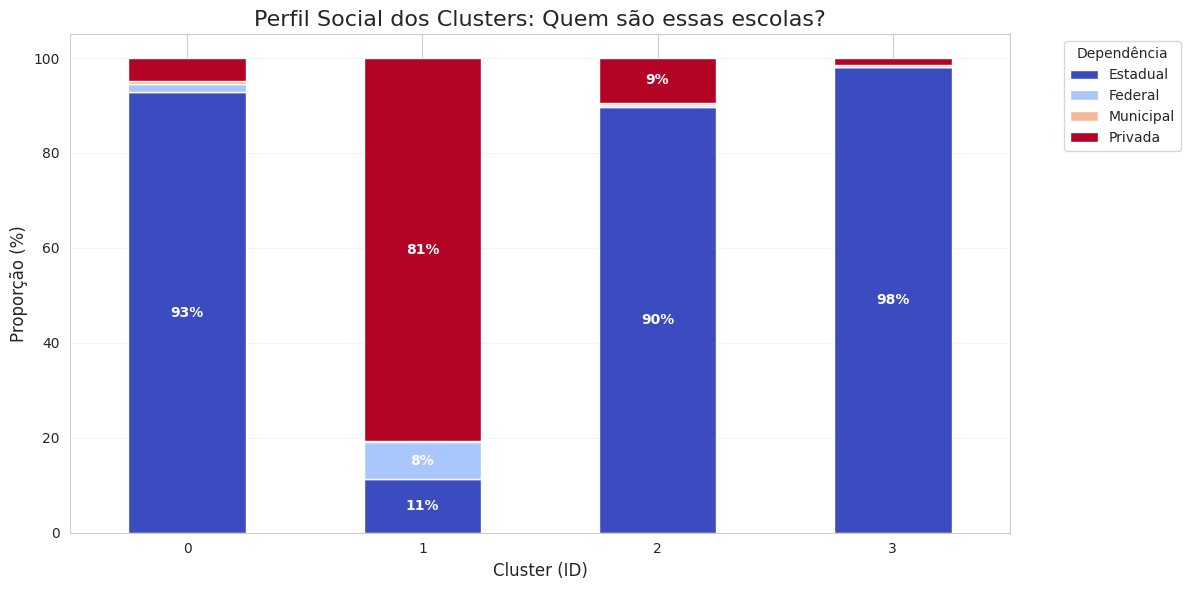


✅ PROJETO DE MINERAÇÃO DE DADOS CONCLUÍDO COM SUCESSO!


In [ ]:
print("--- INICIANDO INVESTIGAÇÃO SOCIAL ---")

# 1. Mapeamento dos Códigos para Nomes (Facilita a leitura)
# Fonte: Dicionário de Dados do INEP
mapa_dependencia = {
    1: 'Federal',
    2: 'Estadual',
    3: 'Municipal',
    4: 'Privada'
}

df_final['TIPO_ESCOLA'] = df_final['TP_DEPENDENCIA'].map(mapa_dependencia)

# 2. Criação da Tabela Cruzada (Crosstab)
# Normalize='index' transforma os valores em porcentagem (soma da linha = 100%)
analise_social = pd.crosstab(df_final['CLUSTER'], df_final['TIPO_ESCOLA'], normalize='index') * 100

print("Composição de cada Cluster por Tipo de Escola (%):")
display(analise_social.round(1))

# 3. Visualização Gráfica
ax = analise_social.plot(
    kind='bar',
    stacked=True,
    colormap='coolwarm',
    figsize=(12, 6),
    edgecolor='white'
)

plt.title('Perfil Social dos Clusters: Quem são essas escolas?', fontsize=16)
plt.ylabel('Proporção (%)', fontsize=12)
plt.xlabel('Cluster (ID)', fontsize=12)
plt.legend(title='Dependência', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)

# Adicionar rótulos de dados nas barras (Opcional, mas chique)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 5: # Só mostra se for relevante (> 5%)
        ax.text(x+width/2, y+height/2, f'{height:.0f}%', ha='center', va='center', color='white', fontweight='bold')

plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()

print("\n✅ PROJETO DE MINERAÇÃO DE DADOS CONCLUÍDO COM SUCESSO!")

### 6. Conclusão e Insights Estratégicos

A aplicação da metodologia KDD neste estudo permitiu processar dados de mais de 25 mil escolas, revelando padrões claros de desigualdade educacional no Brasil. A segmentação matemática (K-Means, validado pelo Método do Cotovelo com K=4) corroborou a hipótese inicial de que a infraestrutura impacta o desempenho, mas trouxe nuances sociológicas importantes.

#### Principais Descobertas (Data-Driven Insights):

**1. O Abismo Público vs. Privado (Cluster 1)**
O **Cluster 1** representa a "Elite Acadêmica". Composto por **81% de escolas privadas**, este grupo possui uma infraestrutura de alta qualidade (Score 7.11) e atinge, com folga, as maiores médias no ENEM (614.6). Isso confirma que o modelo de ensino privado, aliado a boa estrutura, domina o topo do ranking.

**2. O Paradoxo da Infraestrutura Pública (Cluster 0 vs. Cluster 1)**
Uma das descobertas mais valiosas deste estudo está no **Cluster 0**.
* Este grupo possui a **maior infraestrutura de todas** (Score 7.44, superior até às escolas privadas).
* No entanto, sua nota média (502.7) é significativamente inferior à do Cluster 1.
* Sendo composto por **93% de escolas Estaduais/Federais**, isso indica que **apenas ter infraestrutura física (laboratórios, bibliotecas) não é suficiente** para garantir a excelência acadêmica no ensino público. Fatores exógenos (socioeconômicos, gestão, valorização docente) limitam a conversão dessa estrutura em nota.

**3. A Precariedade Crítica (Cluster 3)**
O **Cluster 3** (aprox. 10% da amostra) é o retrato da vulnerabilidade. Composto quase totalmente por escolas públicas (98% Estaduais/Municipais), apresenta infraestrutura crítica (Score 4.0) e as piores notas do país (459). Aqui, a falta de estrutura básica atua como uma barreira instransponível para o aprendizado.

#### Veredito Final
O estudo conclui que **existe uma correlação positiva entre infraestrutura e nota**, mas ela não é linear em todos os cenários:
1.  **Na base da pirâmide:** A falta de infraestrutura "puxa" a nota para baixo (Cluster 3).
2.  **No topo da pirâmide:** Para atingir a excelência (Cluster 1), a infraestrutura é necessária, mas deve vir acompanhada de outros fatores de gestão presentes majoritariamente na rede privada.
3.  **No setor público:** Há um grande volume de escolas bem equipadas (Cluster 0) que ainda não conseguem performar como a elite privada, indicando um ponto focal para políticas públicas pedagógicas, e não apenas estruturais.